# ComBat-seq
- For Michael
- First tried WGCNA on corrected expression, seems much signals were removed (HCP, etc.)
- Now use ComBat-seq to correct batch effect in raw counts (combat input is normalized expression)
- tximport generated raw counts, previously used counts scaled by length
- removed lowly expressed genes, and outlier samples (same set of genes and samples as the main bed file)
- 31947*642
- ComBat-seq could take in biological covariates in addition to batch, i.e. sex/age. Not doing this. Should we..??

In [1]:
library(data.table)
library(tidyverse)
library(sva)

── Attaching packages ──────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0

── Conflicts ─────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()

Loading required package: mgcv

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.8-35. For overview type 'help("mgcv-package")'.

Loading required package: genefilter


Attaching package: ‘genefilter’


The following object is masked from ‘package:readr’:

    spec


Loading r

In [2]:
counts <- fread("../../salmon/expression.final/gene.noVersion.rawCounts.tsv", data.table = F)
# gtf <- fread("../../salmon/gencode.gene.noVersion.tsv", data.table = F)

Warning message in fread("../../salmon/expression.final/gene.noVersion.rawCounts.tsv", :
“Detected 654 column names but the data has 655 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [3]:
which(names(counts) == "1707")

[1]  41 647

In [4]:
# walker and hdbr duplicate 1707
# make hdbr 1707.1
names(counts)[647] <- "1707.1"
rownames(counts) <- counts$V1
counts <- counts[,-1]

In [5]:
# keep to the same set of genes and samples as the main BED file
# note relatives still here, fine
bed <- fread("../data/gene.counts.scaled.normalized.bed.gz", data.table = F)

In [6]:
counts <- counts[rownames(counts) %in% bed$ID, colnames(counts) %in% colnames(bed)]
dim(counts)

[1] 31947   642

In [7]:
# ComBat-seq
walker <- read.table("../../genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_walker.txt")
obrien <-read.table("../../genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_obrien.txt")
werling <-read.table("../../genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_werling.txt")
hdbr <- read.table("../../genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_hdbr.txt")
libd <- read.table("../../genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_libd.txt")

data.batch <- c()

for (i in 1:ncol(counts)) {
  sample <- colnames(counts)[i]
  if (sample %in% walker[,1]) {
    data.batch[i] <- 1
  }
  if (sample %in% obrien[,1]) {
    data.batch[i] <- 2
  }
  if (sample %in% werling[,1]) {
    data.batch[i] <- 3
  }
  if (sample %in% hdbr[,1]) {
    data.batch[i] <- 4
  }
  if (sample %in% libd[,1]) {
    data.batch[i] <- 5
  }
}

In [8]:
table(data.batch)

data.batch
  1   2   3   4   5 
211 119 115 157  40 

In [9]:
adjusted <- ComBat_seq(counts = as.matrix(counts), batch = data.batch)

Found 5 batches
Using null model in ComBat-seq.
Adjusting for 0 covariate(s) or covariate level(s)
Estimating dispersions
Fitting the GLM model
Shrinkage off - using GLM estimates for parameters
Adjusting the data


In [11]:
# ?ComBat_seq

In [15]:
write.table(as.data.frame(adjusted), "../data/genes.combatseq.tsv", col.names = T, row.names = T, quote = F, sep = "\t")

In [16]:
dim(adjusted)

[1] 31947   642

**PCA**

In [12]:
data.batch[data.batch == 1] <- "Walker"
data.batch[data.batch == 2] <- "Obrien"
data.batch[data.batch == 3] <- "Werling"
data.batch[data.batch == 4] <- "HDBR"
data.batch[data.batch == 5] <- "LIBD"

In [14]:
head(adjusted)
head(counts)

,1474,1496,1500,1502,1507,1511,1513,1525,1531,1533,...,1558,1607,1707.1,1835,1851,1890,1923,2193,849,898
ENSG00000000419,1025,594,671,451,287,558,659,508,178,401,...,3138,1018,611,4321,931,1491,7795,574,608,598
ENSG00000000457,737,668,624,660,437,404,611,508,121,437,...,2954,650,530,2955,547,1284,7104,548,760,670
ENSG00000000460,1128,368,689,496,352,509,558,277,96,398,...,1771,644,303,2519,428,1119,4053,351,375,366
ENSG00000000938,6,27,13,13,13,7,6,20,3,7,...,80,149,16,59,35,56,314,17,28,60
ENSG00000000971,116,493,328,103,143,40,225,76,14,129,...,295,1609,537,296,647,2402,4183,566,233,1014
ENSG00000001036,431,389,361,217,229,262,217,284,87,236,...,1367,580,414,1669,488,986,3921,427,436,656


,1474,1496,1500,1502,1507,1511,1513,1525,1531,1533,...,1558,1607,1707.1,1835,1851,1890,1923,2193,849,898
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000419,797.999,491.884,535.548,385.000,243.000,435.000,525.000,412.869,146.000,328.999,...,5808.575,1812.001,1150.001,7592.000,1688.038,2882.931,14677.522,1100.000,1163.000,1160.072
ENSG00000000457,788.140,716.403,657.202,700.871,457.388,431.512,644.429,542.866,142.752,464.630,...,2522.434,554.523,451.497,2524.057,465.999,1092.691,6059.481,466.019,649.253,571.000
ENSG00000000460,961.664,425.473,629.919,511.305,348.256,456.011,538.278,319.704,113.506,388.936,...,1819.479,718.005,293.999,2828.122,433.000,1147.254,3970.131,347.000,373.095,355.002
ENSG00000000938,5.000,16.000,9.000,9.000,8.000,5.000,5.000,12.001,2.000,5.000,...,101.000,149.000,19.000,70.999,49.000,72.000,433.000,21.000,37.001,90.000
ENSG00000000971,77.716,111.673,88.847,67.000,52.001,37.000,77.000,52.468,16.432,53.074,...,391.301,4120.101,1208.226,401.000,1462.841,5779.254,8619.220,1273.815,434.461,2448.044
ENSG00000001036,354.028,321.914,291.585,214.246,189.199,208.970,206.448,236.754,77.219,197.996,...,2135.000,997.000,686.000,2741.297,808.000,1579.056,6155.092,704.000,717.000,1140.254


**12/7/2023 batch correction check**

In [34]:
pca_result <- prcomp(t(adjusted))

pca_data <- data.frame(PC1 = pca_result$x[,1],
                       PC2 = pca_result$x[,2],
                       Batch = data.batch)

In [16]:
range(pca_data$PC1)
range(pca_data$PC2)

[1] -1253933 16659940

[1] -7228881  6372455

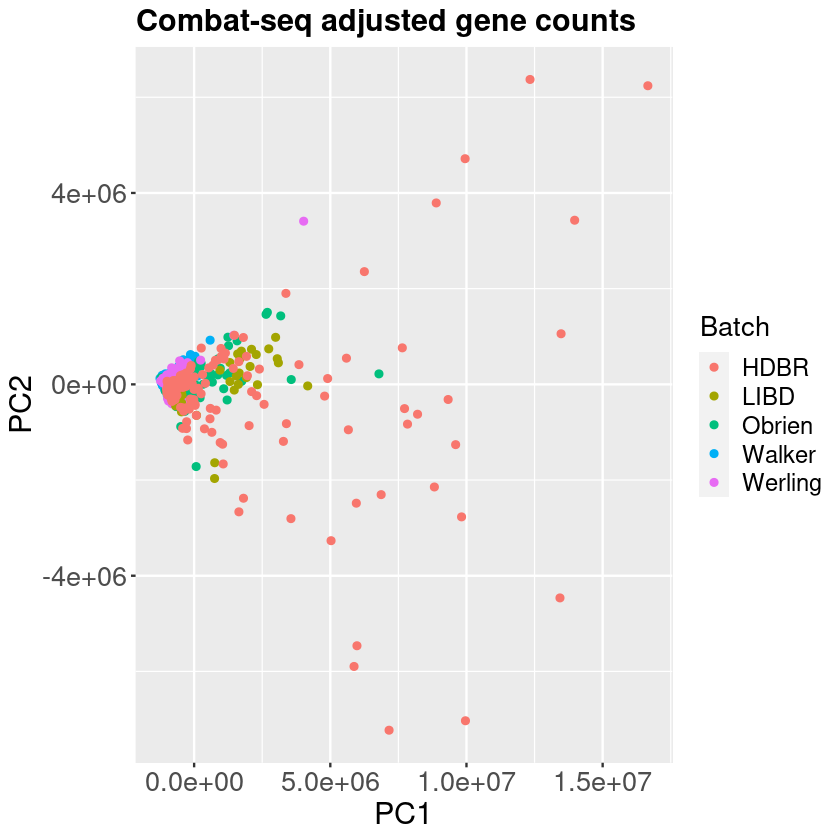

In [35]:
ggplot(pca_data, aes(x = PC1, y = PC2, color = Batch)) +
  geom_point() +
  labs(x = "PC1", y = "PC2", title = "Combat-seq adjusted gene counts") +
    theme(axis.text = element_text(size=16),
          axis.title = element_text(size=18),
          plot.title = element_text(size=18, face="bold"),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14))

Warning message:
“Removed 71 rows containing missing values (`geom_point()`).”


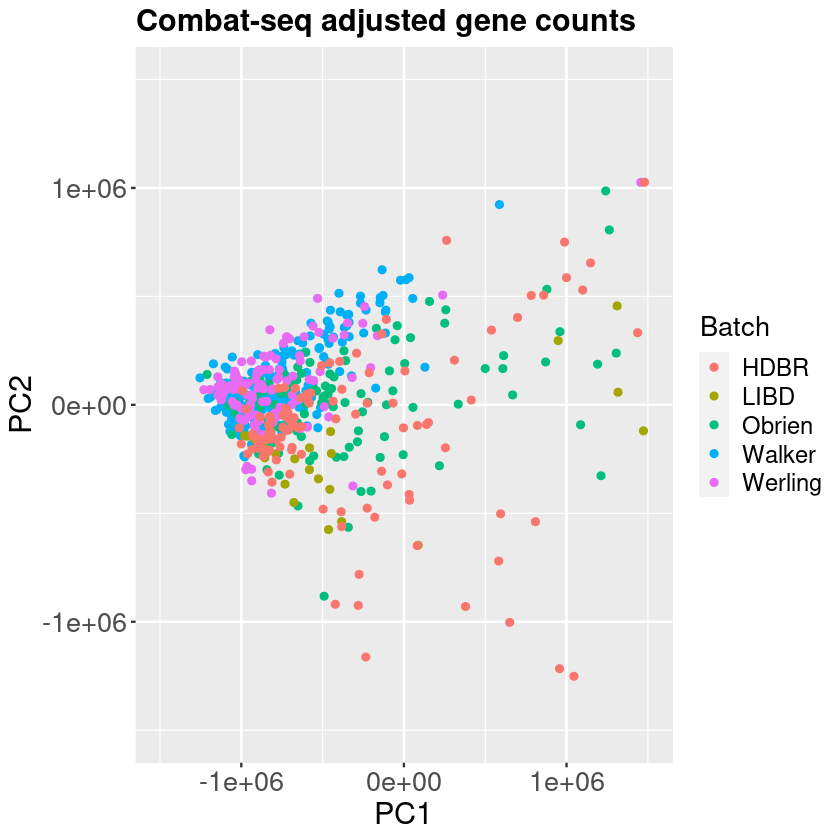

In [33]:
ggplot(pca_data, aes(x = PC1, y = PC2, color = Batch)) +
  geom_point() +
  labs(x = "PC1", y = "PC2", title = "Combat-seq adjusted gene counts") +
    xlim(-1.5e6, 1.5e6) +
    ylim(-1.5e6, 1.5e6) +
    theme(axis.text = element_text(size=16),
          axis.title = element_text(size=18),
          plot.title = element_text(size=18, face="bold"),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14))

In [36]:
pca_result1 <- prcomp(t(counts))

pca_data1 <- data.frame(PC1 = pca_result1$x[,1],
                       PC2 = pca_result1$x[,2],
                       Batch = data.batch)

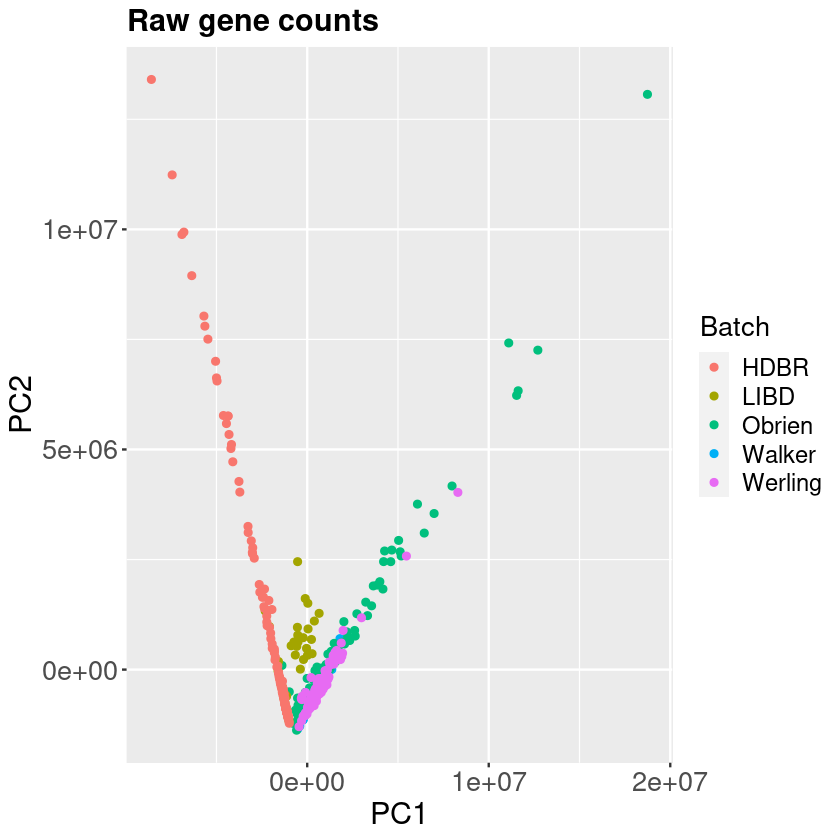

In [37]:
ggplot(pca_data1, aes(x = PC1, y = PC2, color = Batch)) +
  geom_point() +
  labs(x = "PC1", y = "PC2", title = "Raw gene counts") +
    theme(axis.text = element_text(size=16),
          axis.title = element_text(size=18),
          plot.title = element_text(size=18, face="bold"),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14))

**original batch correction check**

In [18]:
s <- svd(counts - rowMeans(counts))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = factor(data.batch))

In [19]:
s_1 <- svd(adjusted - rowMeans(adjusted))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = factor(data.batch))

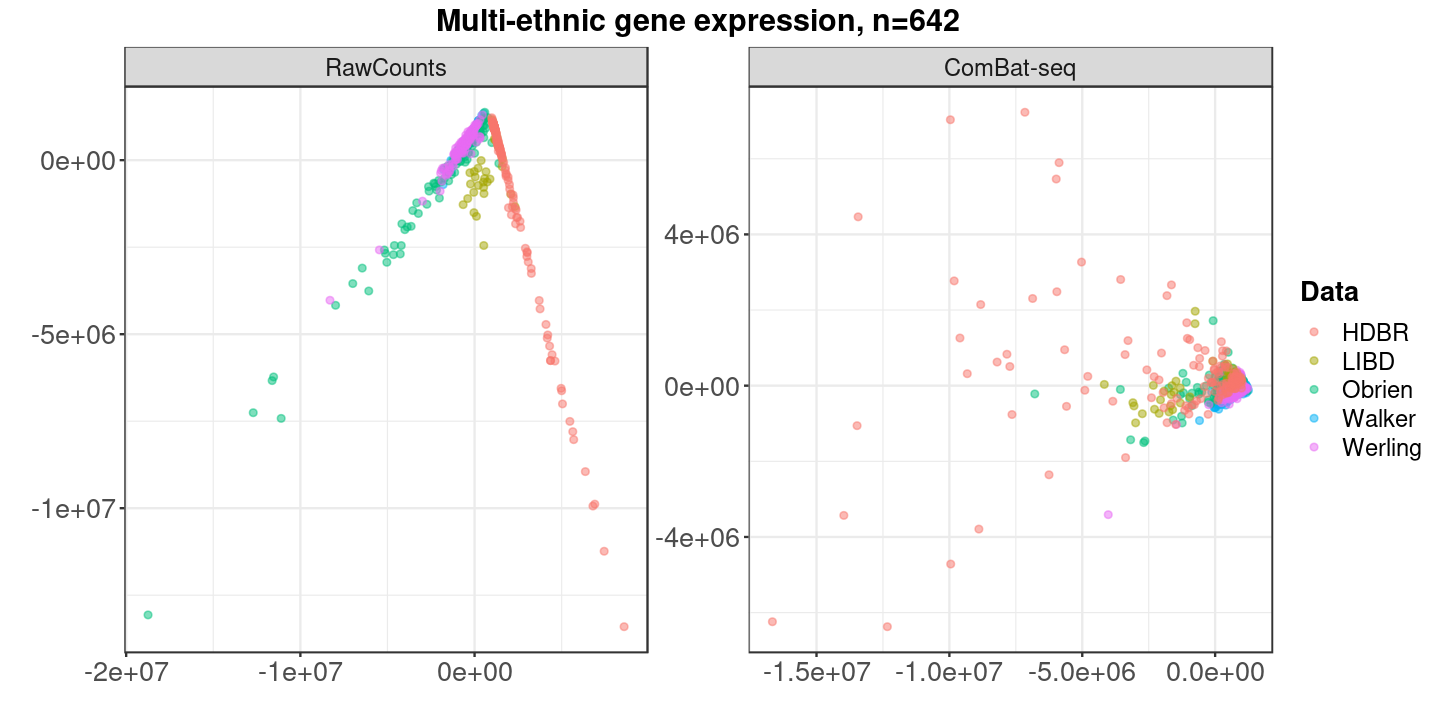

In [21]:
options(repr.plot.width = 12, repr.plot.height = 6)

colnames(data1) <- c("PC1", "PC2", "Data")
data_combine <- rbind(data, data1)

data_combine$group <- c(rep("RawCounts", dim(data)[1]), 
                        rep("ComBat-seq", dim(data1)[1]))
data_combine$group <- factor(data_combine$group, levels = c("RawCounts", "ComBat-seq"))

ggplot(data_combine, aes(x = PC1, y = PC2, color = Data)) +
  geom_point(alpha = 0.5) +
  facet_wrap(~group, scales = "free") +
  labs(title = "Multi-ethnic gene expression, n=642", x = "", y = "") +
  theme_bw() +
  theme(axis.text = element_text(size = 16),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
        strip.text.x = element_text(size = 14),
        legend.title = element_text(size = 16, face = "bold"),
        legend.text = element_text(size = 14))